# Lab 3 — clustering

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.cluster import KMeans

%matplotlib inline
plt.style.use("ggplot")

## Exercise 3.11 - Clustering tags

Load the tag embedding that you created at the end of Exercise 3.2

In [2]:
with open('tags_mapped.pickle', 'rb') as handle:
    tags_mapped = pickle.load(handle, encoding='utf-8')
with open('tag_embedding.pickle', 'rb') as handle:
    tag_embedding = pickle.load(handle, encoding='utf-8')

* Cluster the data using the k-means clustering algorithm. Try k∈{2,...,5}.

In [3]:
models=[]

for k in range(2,6):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(tag_embedding)
    models.append(kmeans)


*  Visualize the clusters using an interactive bokeh plot.

In [4]:
import bokeh.plotting
from bokeh.plotting import figure
from bokeh.io import output_file
from sklearn import datasets

def kmeans_bokeh(kmean, first_component=0, second_component=1,center=True):
    bokeh.plotting.output_notebook()
    
    #initialize plot
    plot = figure(width=500, height=500, title='K-means clustering on PCA-reduced movies data, '+str(kmean.n_clusters)+" clusters", x_axis_label = "Principal Component "+str(first_component), y_axis_label = "Principal Component "+str(second_component))

    #plot centroid - group mean for each group
    centroids=np.transpose(kmean.cluster_centers_)
    clus_xs = centroids[0]
    clus_ys = centroids[1]
    
    colors = ["red", "green", "blue", "orange", "purple"]
    
    for label in np.unique(kmean.labels_):
        indices = np.where(kmean.labels_ == label)[0]
        color = colors[label]
        #get data along components
        x_samples = tag_embedding[indices, first_component]
        y_samples = tag_embedding[indices, second_component]
        plot.circle(x=x_samples, y=y_samples, size=5, color=color)
        if center:
            plot.cross(x=clus_xs,y=clus_ys,size=17,line_width=4,angle=0.8,color="black")
        
    bokeh.plotting.show(plot)


In [5]:
kmeans_bokeh(models[0])

Loading BokehJS ...

In [6]:
kmeans_bokeh(models[1])

Loading BokehJS ...

In [7]:
kmeans_bokeh(models[2])

Loading BokehJS ...

In [8]:
kmeans_bokeh(models[3])

Loading BokehJS ...

* Try projecting on different principal directions.

In [9]:
#compute and visualize in one
def kmeans_visual(k,first_pc=0,second_pc=1):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(tag_embedding)
    kmeans_bokeh(kmeans,first_pc,second_pc,center=False)

First Fix component one and change second component

In [10]:
kmeans_visual(2,0,1)

Loading BokehJS ...

In [11]:
kmeans_visual(2,0,2)

Loading BokehJS ...

In [12]:
kmeans_visual(2,0,3)

Loading BokehJS ...

In [13]:
kmeans_visual(2,0,3)

Loading BokehJS ...

In [14]:
kmeans_visual(2,0,4)

Loading BokehJS ...

In [16]:
kmeans_visual(4,0,2)

Loading BokehJS ...

In [17]:
kmeans_visual(4,0,3)

Loading BokehJS ...

In [18]:
kmeans_visual(4,0,4)

Loading BokehJS ...

Try To change first and second component to lower ones

In [21]:
kmeans_visual(2,2,4)

Loading BokehJS ...

In [22]:
kmeans_visual(4,2,4)

Loading BokehJS ...

* Which principal directions separate the clusters well?

As one can see in the first graphs above, when still using the first principal component and varying the second the separation still works quite well (The first two principal components are best, though). The too cluster model is separated well but we can see much more variance in the points, meaning the points of each cluster are not as packed/ not as close together. For four clusters using other components with the first ones causes some little overlaps of points at the edges of the clusters. 

Not using the first component leads to no real visible separation at all, the point seem all to lie one on another. That it understandable becasue the first principal component contains the most variance and can thus separate the data the best. The seperations on lower components cannot be seen in a 2D graph, if the first component is not used. Hence the first principal comonent is crucial for good clustering.

---
## Exercise 3.12 - Clustering movies

Create a `dict` that maps movie IDs to set of genres from the data in `movies.txt`.


In [23]:
movies_rdd = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)


from pyspark.sql import SQLContext, Row
movies_DF = movies_rdd.map(lambda l: Row(**dict(l))).toDF()

with open('most-rated.pickle', 'rb') as handle:
    most_rated = pickle.load(handle, encoding='utf-8')

In [24]:
print(movies_DF.first())
#print(movies_df.first())

Row(genres=['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'], movieId=1, title='Toy Story (1995)')


* Implement the k-medioids algorithm with the Jaccard distance.

In [25]:
def jacc_dist(medioid, point):
    med = set(medioid)
    p = set(point)

    J = len(set.intersection(med, p)) / len(set.union(med, p))
    return 1.0 - J

In [26]:
import random
import copy

def k_medioids(points, d, k,convergence_point=10**(-4)):
    centers = [None] * k
    
    #initialize random centers
    for i in range(k): 
        random_point = random.choice(list(points.keys()))
        centers[i] = points[random_point]
        
        
    count = 1
    distances_sum = np.zeros(k)
    
    while(True):
        Cs = [None]*k
        for i in range(k):
            Cs[i] = []
        #assign points to clusters with closest medioid    
        for point_key, point_value in points.items():
            distances = []
            for index, medioid in enumerate(centers):
                dist = d(medioid, point_value)
                distances.append(dist)
            i = np.argmin(distances)
            Cs[i].append(point_key)
        
        old_centers = copy.deepcopy(centers)
        old_distances_sum = copy.deepcopy(distances_sum)
        
        #recompute medioids
        for i in range(k):
            Ci = Cs[i]
            
            min_distances = []
            for point_id in Ci:
                
                #compute distance sum of the points in clutser i
                distance_sum = 0.0
                x_in_Ci = points[point_id]
                for point_id_2 in Ci:
                    y_in_Ci = points[point_id_2]
                    distance_sum += d(x_in_Ci, y_in_Ci)
                min_distances += [distance_sum]
                
            distances_sum[i] = np.sum(min_distances)
            #get arg min new medioid for cluster i
            new_medioid = Ci[np.argmin(min_distances)]
            centers[i] = points[new_medioid]

        count += 1
        #until convergence, meaning the monioidsdo not change and the distamce sum only a little
        if np.abs(np.sum(distances_sum-old_distances_sum)) < convergence_point and old_centers == centers:
            print('Converged after ',count,' rounds.')
            break
            
    return centers, Cs

* Cluster the set of movies in the file most-rated.pickle, using k=2.

In [28]:
most_rated_genres = {}
#get the genres of the most rated movies, to do clustering
for movie in most_rated:
    most_rated_genres[movie[0]] = movies_DF.where('movieId = ' + str(movie[0])).collect()[0]['genres']

In [29]:
centers,Cs=k_medioids(most_rated_genres, jacc_dist, 2)

Converged after  4  rounds.


* Find a good way to visualize the results of the clustering. For example, you could try to visually represent the frequency of the genres in each of the clusters.

In [30]:
#count tag frequency for both clusters
tag_frequency={}

for i in range(2):
    cluster=Cs[i]
    for movie_id in cluster:
        #get tags 
        tags=most_rated_genres[movie_id]
        for tag in tags:
            tag_freq=tag_frequency.get(tag,[0,0])
            tag_freq[i]+=1
            tag_frequency[tag]=tag_freq

    

In [31]:
tag_frequency

{'Action': [262, 28],
 'Adventure': [205, 23],
 'Animation': [51, 11],
 'Children': [65, 17],
 'Comedy': [299, 92],
 'Crime': [103, 58],
 'Documentary': [5, 1],
 'Drama': [60, 388],
 'Fantasy': [91, 22],
 'Film-Noir': [7, 6],
 'Horror': [58, 14],
 'IMAX': [18, 4],
 'Musical': [31, 13],
 'Mystery': [50, 34],
 'Romance': [89, 109],
 'Sci-Fi': [142, 27],
 'Thriller': [201, 69],
 'War': [15, 35],
 'Western': [17, 6]}

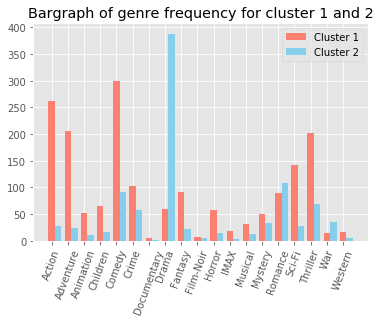

In [34]:
ind = np.arange(len(tag_frequency))
width = 0.4

g, ax = plt.subplots()
rects1 = ax.bar(ind, [tag_frequency[tag][0] for tag in sorted(tag_frequency.keys())], width, color='salmon') 
rects2 = ax.bar(ind + width, [tag_frequency[tag][1] for tag in sorted(tag_frequency.keys())], width, color='skyblue') 

plt.title("Bargraph of genre frequency for cluster 1 and 2")
plt.xticks(range(len(tag_frequency)), sorted(tag_frequency.keys()), rotation=70)


ax.legend((rects1[0], rects2[0]), ("Cluster 1", "Cluster 2"))
plt.show()

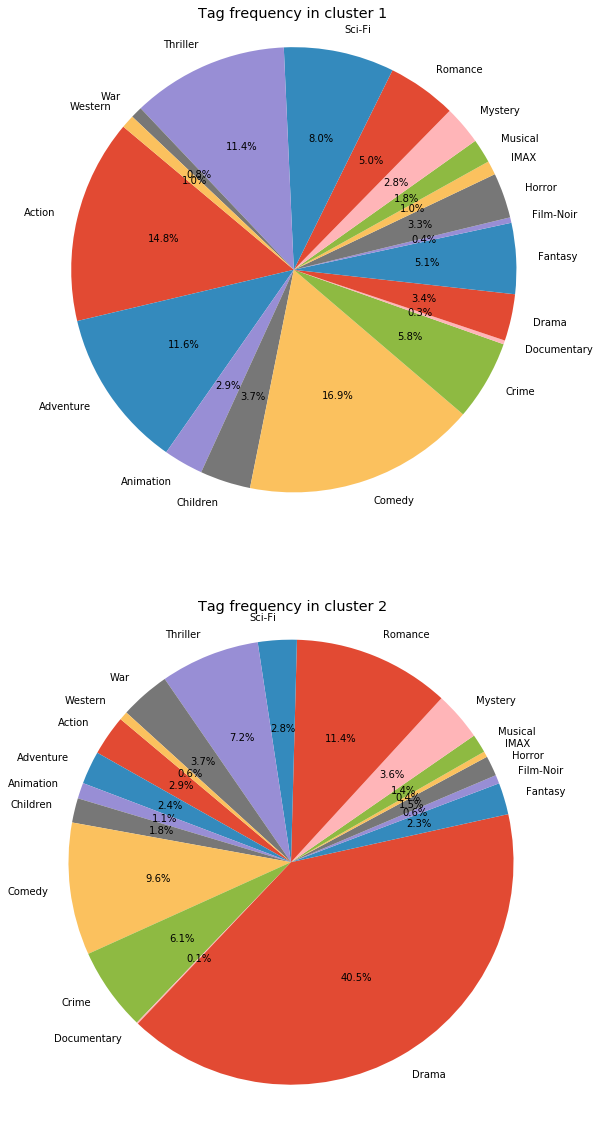

In [35]:

plt.figure(figsize=(10,20))
plt.subplot(211)


# Data to plot
labels = sorted(tag_frequency.keys())
sizes = [tag_frequency[tag][0] for tag in sorted(tag_frequency.keys())]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode = (0, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels,
        autopct='%1.1f%%', startangle=140)
plt.title("Tag frequency in cluster 1")
 
plt.axis('equal')


plt.subplot(212)



# Data to plot
labels = sorted(tag_frequency.keys())
sizes = [tag_frequency[tag][1] for tag in sorted(tag_frequency.keys())]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode = (0, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels,
        autopct='%1.1f%%', startangle=140)

plt.title("Tag frequency in cluster 2")

 
plt.axis('equal')
plt.show()

How do you intepret the two clusters?

The second cluster has a big majority of drama movies, followed by romance, comedy and Thriller respectively but far behind drama (41%).

The first cluster's most used tags are comedy, action, adventure, thriller respectively. The tags are distributed much more evenly over those for tags, the biggest one making up only 17 %. 

Hence it seems that the second cluster deals with more serious movies, that are maybe a little bit heavier on the emotions while cluster one seems to have lighter, and less serious movies. 